This Jupyter notebook serves as a first user guide to beta testers of EIS Toolkit. It shows how to import and call various tools of EIS Toolkit and includes steps of a simple MPM workflow.

Note that to run this notebook without modifications you need to have the test data (and under correct folder structure). One can always change the filepaths and use their own data, granted that the data is in right the format and is meaningful geospatial data. However, the primary function of this notebook is not to provide a template for conducting MPM workflows, but instead serve as example and showcase some of the tools of EIS Toolkit.

### 1. Imports and filepath definitions

In [2]:
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from rasterio.plot import show
import tempfile

import sys
sys.path.insert(0, "..")

from eis_toolkit.exploratory_analyses.basic_plots_seaborn import histogram, pairplot
from eis_toolkit.exploratory_analyses.descriptive_statistics import descriptive_statistics_dataframe
from eis_toolkit.exploratory_analyses.pca import compute_pca

from eis_toolkit.prediction.fuzzy_overlay import gamma_overlay
from eis_toolkit.prediction.weights_of_evidence import weights_of_evidence_calculate_weights, weights_of_evidence_calculate_responses

from eis_toolkit.raster_processing.extract_values_from_raster import extract_values_from_raster
from eis_toolkit.raster_processing.unifying import unify_raster_grids

from eis_toolkit.transformations.sigmoid import _sigmoid_transform
from eis_toolkit.transformations.linear import _min_max_scaling

from eis_toolkit.vector_processing.idw_interpolation import idw
from eis_toolkit.vector_processing.distance_computation import distance_computation
from eis_toolkit.vector_processing.rasterize_vector import rasterize_vector

In [3]:
# Filepaths
AEM_inphase_fp = "../tests/data/local/workflow_demo/IOCG_AEM_Inph_.tif"
AEM_quad_fp = "../tests/data/local/workflow_demo/IOCG_AEM_Quad.tif"
AEM_ratio_fp = "../tests/data/local/workflow_demo/IOCG_EM_ratio.tif"
Magn_AS_fp = "../tests/data/local/workflow_demo/Mag_DGRF_AS_FFT_ers_PCS_tif_clip.tif"

till_geochem_fp = "../tests/data/local/workflow_demo/Geochemical_Data/Vector_files/IOCG_CLB_Till_Geochem_reg_511p.shp"
structures_fp = "../tests/data/local/workflow_demo/Geological_Data/IOCG_CLB_Structures_1M.shp"
lithology_fp = "../tests/data/local/workflow_demo/Geological_Data/IOCG_CLB_Lith_Asstn_1M.shp"
known_occurances_fp = "../tests/data/local/workflow_demo/Deposits_Occurrences/IOCG_Deps_Prosp_Occs.shp"

### 2. Preprocess data

In [4]:
# Take AEM_inphase raster profile and grid shape as the base/target
with rasterio.open(AEM_inphase_fp) as AEM_inphase:
    raster_profile = AEM_inphase.profile
    raster_extent = AEM_inphase.bounds
    raster_pixel_size = AEM_inphase.transform[0]

In [ ]:
# Preprocess geochemical data
till_geochem = gpd.read_file(till_geochem_fp)

columns_to_process = ["Fe_ppm_511", "Co_ppm_511", "Cu_ppm_511"]

interpolation_results = {}
interpolation_extent = (raster_extent[0], raster_extent[2], raster_extent[1], raster_extent[3])  # NOTE: Rasterio's extent order differs from IDW's

# Log transform concentrations and interpolate
# NOTE: EIS Toolkit implements transforms only for rasters at the moment, there we use directly np.log here
for column in columns_to_process:
    new_col_name = column[:2] + "_log"
    till_geochem[new_col_name] = np.log(till_geochem[column])

    interpolation_results[new_col_name] = idw(till_geochem, new_col_name, (500, 500), interpolation_extent)

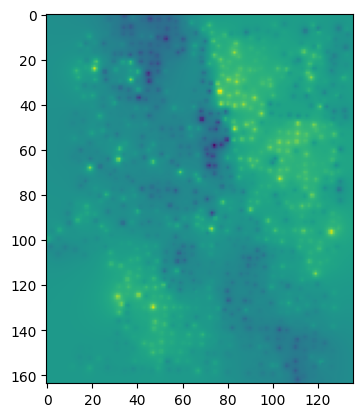

In [6]:
# Visualize copper interpolated
plt.imshow(interpolation_results["Cu_log"][0])

In [60]:
# Preprocess geological data
structures = gpd.read_file(structures_fp)

distances_to_stuctures = distance_computation(raster_profile, structures)

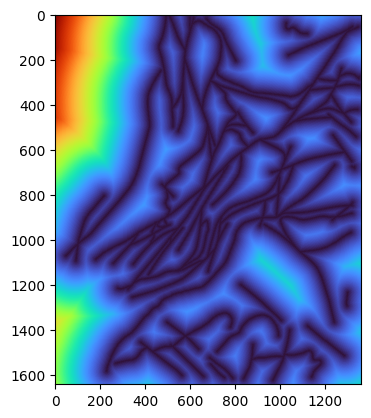

In [7]:
# Visualize distances to structures
plt.imshow(distances_to_stuctures, cmap="turbo")

In [8]:
# Rasterize lithology
lithology = gpd.read_file(lithology_fp)
rasterized_lithology, lithology_out_meta = rasterize_vector(lithology, base_raster_profile=raster_profile)

In [9]:
# Extract raster values at deposits
known_occurances = gpd.read_file(known_occurances_fp)

# Open rasters with context manager, save lithology data to temporary raster file so we can use the extract function on it
with \
    MemoryFile() as memfile, \
    rasterio.open(AEM_inphase_fp) as AEM_inphase, \
    rasterio.open(AEM_quad_fp) as AEM_quad, \
    rasterio.open(AEM_ratio_fp) as AEM_ratio, \
    rasterio.open(Magn_AS_fp) as Magn_AS:

    with tempfile.NamedTemporaryFile() as tmpfile:
        with rasterio.open(tmpfile.name, "w", **raster_profile) as dest:
            dest.write(rasterized_lithology, 1)
        with rasterio.open(tmpfile.name) as lithology_raster:
            raster_list = [AEM_inphase, AEM_quad, AEM_ratio, Magn_AS, lithology_raster]
            col_names = ["AEM_inphase", "AEM_quad", "AEM_ratio", "Magn_AS", "Lithology"]
            raster_values_at_deposits = extract_values_from_raster(raster_list, known_occurances, col_names)

            unified_rasters = unify_raster_grids(AEM_inphase, raster_list[1:-1], same_extent=True)

raster_values_at_deposits

,x,y,AEM_inphase,AEM_quad,AEM_ratio,Magn_AS,Lithology
0,370953.0,7502821.0,-408.969513,369.960022,-1.059486,17.158161,1.0
1,371340.0,7496345.0,3889.745605,2384.806152,1.817769,21.545200,1.0
2,385205.0,7497926.0,-339.839050,187.980026,-1.730280,14.112287,1.0
3,369187.0,7490345.0,1468.369385,1285.413208,1.034502,20.598907,1.0
4,368175.0,7489722.0,537.748718,324.102142,1.903474,43.523659,1.0
5,350043.0,7489418.0,-6.511929,625.734375,0.025980,72.489517,1.0
6,363838.0,7492354.0,-435.950928,248.234833,-1.672447,8.311082,1.0
7,364672.0,7482684.0,-210.937698,1754.664917,-0.309453,31.408430,1.0
8,396649.0,7501845.0,-373.599243,440.641846,-1.192332,12.663096,1.0
9,372344.0,7492293.0,-885.269836,675.116272,-2.274024,8.680225,1.0


### 3. Explore data

#### Explore rasters

In [10]:
# Calculate basic statistics of rasters at deposit locations
inphase_stats_at_points = descriptive_statistics_dataframe(raster_values_at_deposits, "AEM_inphase")
quad_stats_at_points = descriptive_statistics_dataframe(raster_values_at_deposits, "AEM_quad")
ratio_stats_at_points = descriptive_statistics_dataframe(raster_values_at_deposits, "AEM_ratio")
magn_stats_at_points = descriptive_statistics_dataframe(raster_values_at_deposits, "Magn_AS")

stats_dataframe = pd.DataFrame(
    {
        'inphase':pd.Series(inphase_stats_at_points),
        'quad':pd.Series(quad_stats_at_points),
        'ratio':pd.Series(ratio_stats_at_points),
        'magn':pd.Series(magn_stats_at_points),
    }
)
stats_dataframe

,inphase,quad,ratio,magn
min,-885.269836,187.980026,-2.274024,5.490668
max,3889.745605,2384.806152,1.903474,72.489517
mean,278.655135,774.591645,-0.215454,26.171717
25%,-373.599243,369.960022,-1.192332,12.663096
50%,-210.937698,578.203674,-0.309453,20.598907
75%,537.748718,675.116272,1.034502,31.408430
standard_deviation,1191.602431,623.131335,1.315682,19.687020
relative_standard_deviation,4.276262,0.804464,-6.106545,0.752225
skew,2.079341,1.489026,0.191099,1.145725


<Axes: ylabel='Count'>

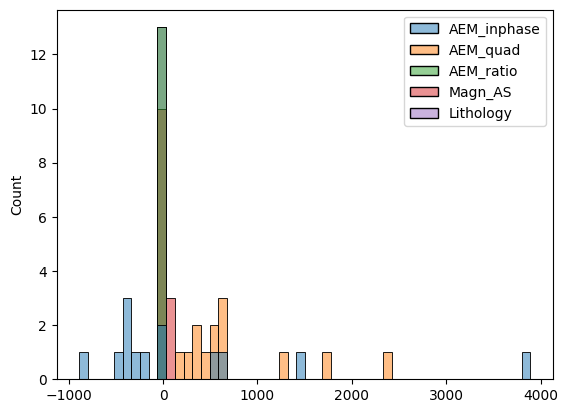

In [11]:
# Plot histogram of raster values at deposit locations
histogram(raster_values_at_deposits.drop(["x", "y"], axis=1))

#### Explore geochemical data (vector data)

/home/niko/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


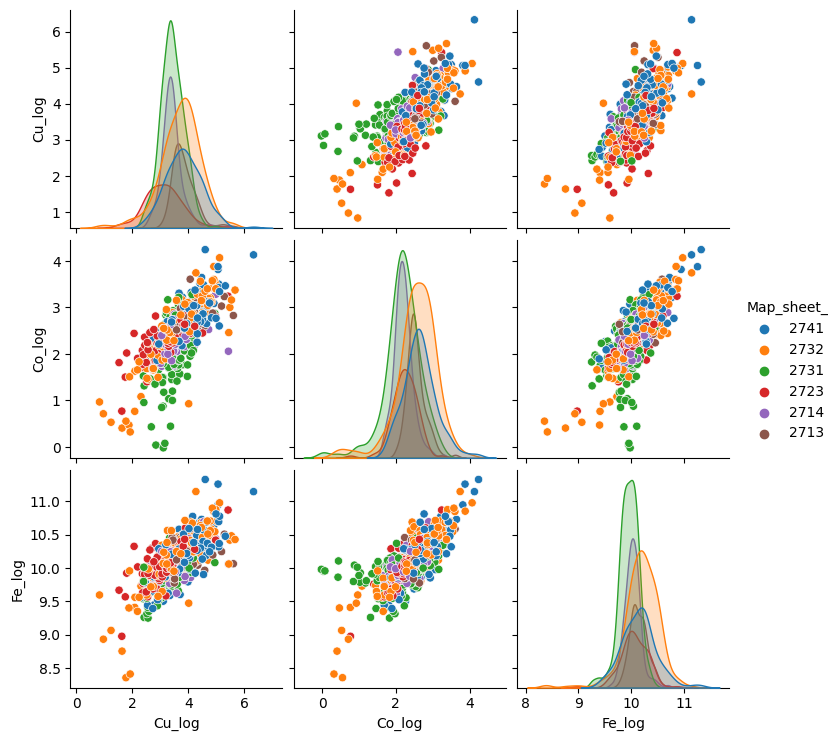

In [23]:
# Plot pairplot of various log transformed concentrations
pairplot(till_geochem[["Cu_log", "Co_log", "Fe_log", "Map_sheet_"]], hue="Map_sheet_")

In [42]:
# Define cmap to use in the following visualizations
cmap = plt.get_cmap('jet')

#### Explore raster data with PCA

In [161]:
# Preprocess nodata before modeling (for these rasters, min value is the nodata value)
arrays_to_stack = []

for raster_array, meta in unified_rasters:
    raster_array[raster_array == np.nanmin(raster_array)] = np.nan
    arrays_to_stack.append(raster_array[0])

stacked_arrays = np.stack(arrays_to_stack)

In [170]:
# Compute PCA for the input rasters
out_array, explained_variances = compute_pca(stacked_arrays, 3)
explained_variances

array([0.41700809, 0.32194577, 0.16958726])

/tmp/ipykernel_83370/1271570867.py:13: RuntimeWarning: invalid value encountered in cast
  show(scaled_pca_output.astype(np.uint8), transform=raster_profile["transform"])


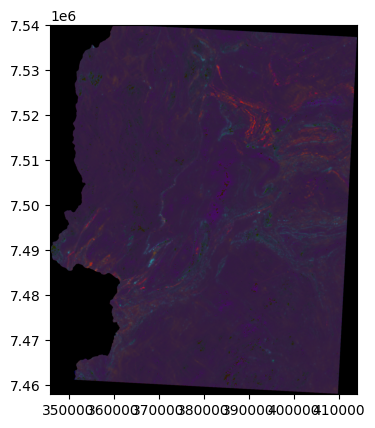

<Axes: >

In [168]:
# Visualize PCA outputs

# Scale each band
scaled_bands = []
for band in range(out_array.shape[0]):
    scaled_band = _min_max_scaling(out_array[band], (0, 255))
    scaled_bands.append(scaled_band)

# Stack scaled bands back together
scaled_pca_output = np.stack(scaled_bands)

# Display the RGB image
show(scaled_pca_output.astype(np.uint8), transform=raster_profile["transform"])

### 4. Fuzzy logic modeling

In [53]:
# Transform data before fuzzy overlay
arrays_to_stack = []
for raster_array, meta in unified_rasters:
    raster_array[raster_array == np.nanmin(raster_array)] = np.nan
    out_array = _sigmoid_transform(raster_array, (0, 1), 1, True)
    arrays_to_stack.append(out_array[0])

transformed_arrays_for_fuzzy_overlay = np.stack(arrays_to_stack)

In [54]:
# Compute gamma overlay
overlay_result = gamma_overlay(transformed_arrays_for_fuzzy_overlay, 0.5)

<Axes: title={'center': 'Gamma overlay result'}>

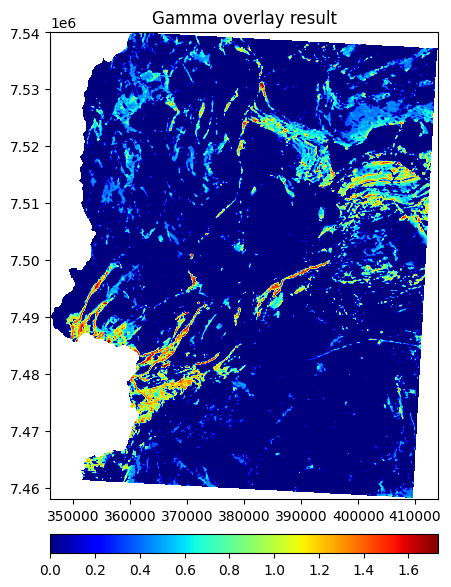

In [55]:
# Plot gamma ovelay result
fig, ax = plt.subplots(1, 1, figsize = (5, 9))

ax.set_title("Gamma overlay result")
clrbar = plt.imshow(overlay_result, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(overlay_result, ax = ax, transform = raster_profile["transform"], cmap=cmap)

### 5. Weights of evidence modeling

In [56]:
# Calculate weights
with rasterio.open("../tests/data/remote/wofe/wofe_evidence_raster.tif") as evidence_raster:
    deposits = gpd.read_file("../tests/data/remote/wofe/wofe_deposits.shp")

    weights_desc, arrays_desc, out_meta, deposit_pixels, evidence_pixels = weights_of_evidence_calculate_weights(
        evidential_raster=evidence_raster,
        deposits=deposits,
        weights_type='descending', 
        studentized_contrast_threshold=1
    )

    weights_asc, arrays_asc, _, _, _ = weights_of_evidence_calculate_weights(
        evidential_raster=evidence_raster,
        deposits=deposits,
        weights_type='ascending', 
        studentized_contrast_threshold=1
    )

<Axes: title={'center': 'Descending weights - Generalized S_W+'}>

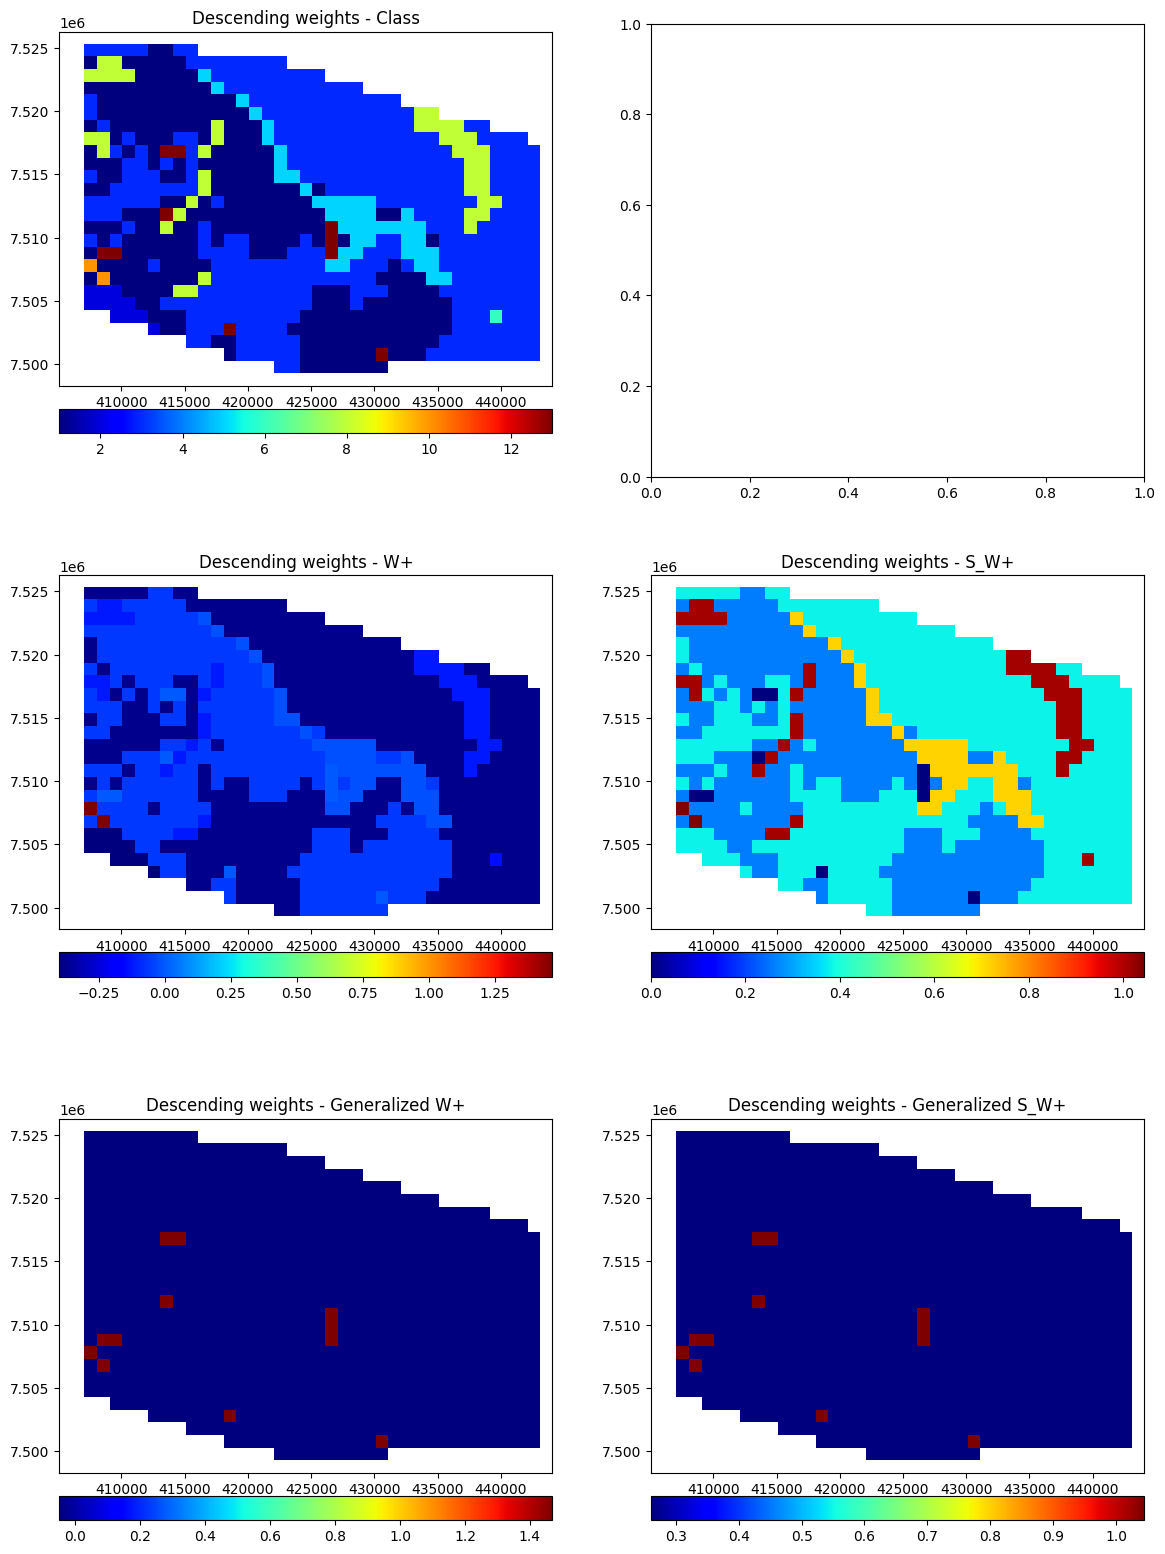

In [57]:
# Plot descending weights
fig, axs = plt.subplots(3, 2, figsize = (14, 20))

axs[0, 0].set_title("Descending weights - Class")
clrbar = axs[0, 0].imshow(arrays_desc["Class"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_desc["Class"], ax = axs[0, 0], transform = out_meta["transform"], cmap=cmap)

axs[1, 0].set_title("Descending weights - W+")
clrbar = axs[1, 0].imshow(arrays_desc["W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_desc["W+"], ax = axs[1, 0], transform = out_meta["transform"], cmap=cmap)

axs[1, 1].set_title("Descending weights - S_W+")
clrbar = axs[1, 1].imshow(arrays_desc["S_W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_desc["S_W+"], ax = axs[1, 1], transform = out_meta["transform"], cmap=cmap)

axs[2, 0].set_title("Descending weights - Generalized W+")
clrbar = axs[2, 0].imshow(arrays_desc["Generalized W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_desc["Generalized W+"], ax = axs[2, 0], transform = out_meta["transform"], cmap=cmap)

axs[2, 1].set_title("Descending weights - Generalized S_W+")
clrbar = axs[2, 1].imshow(arrays_desc["Generalized S_W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_desc["Generalized S_W+"], ax = axs[2, 1], transform = out_meta["transform"], cmap=cmap)

In [58]:
# Calculate posterior probabilities / responses
posterior_array, posterior_array_std, posterior_confidence = weights_of_evidence_calculate_responses([arrays_asc, arrays_desc], deposit_pixels, evidence_pixels)

<Axes: title={'center': 'Posterior confidence'}>

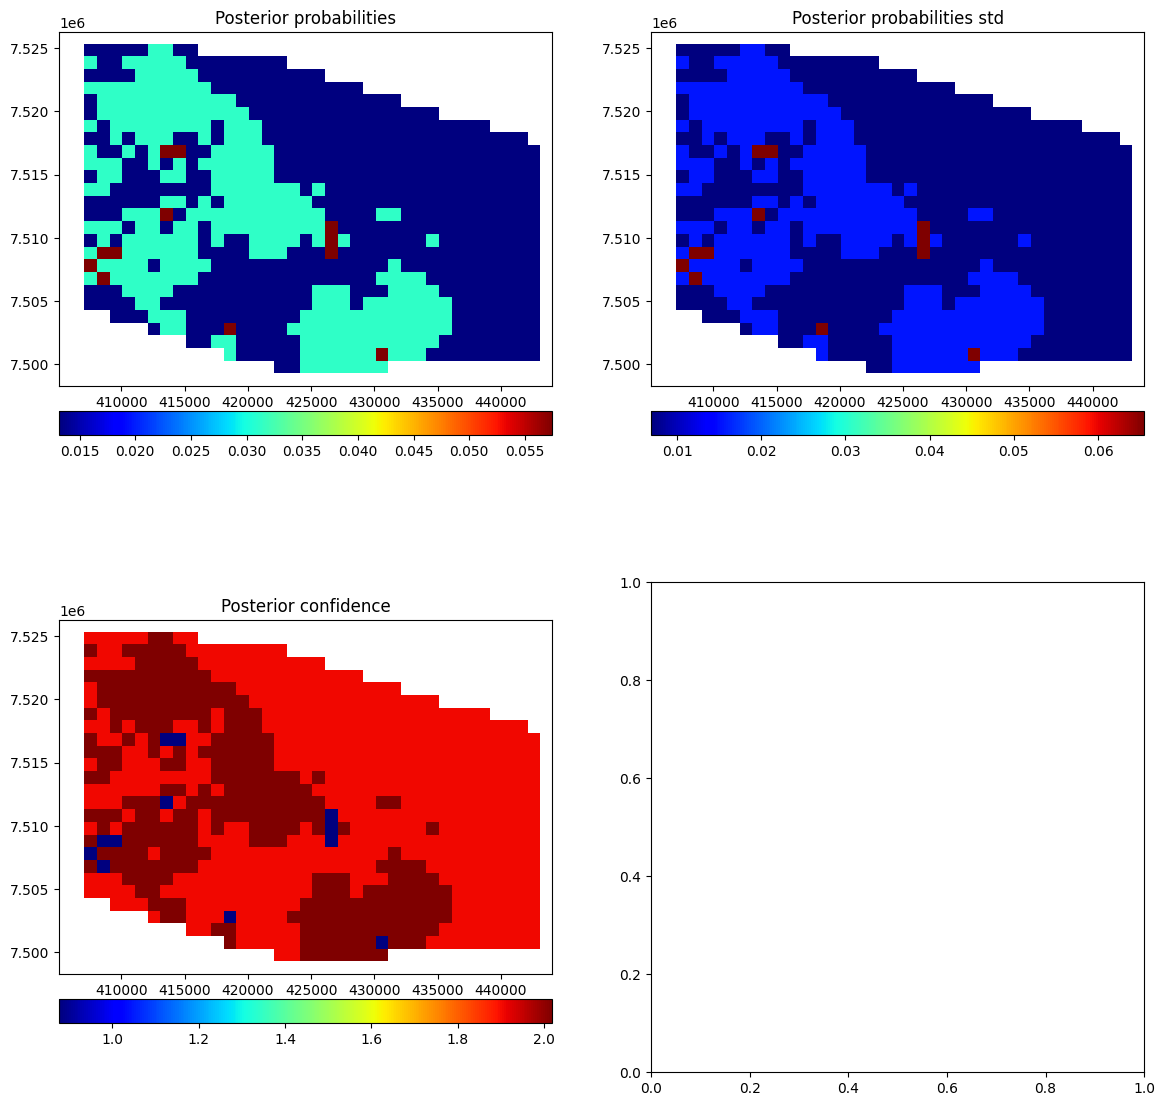

In [59]:
# Plot posterior probabilities weights

fig, axs = plt.subplots(2, 2, figsize = (14, 14))

axs[0, 0].set_title("Posterior probabilities")
clrbar = axs[0, 0].imshow(posterior_array, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(posterior_array, ax = axs[0, 0], transform = out_meta["transform"], cmap=cmap)

axs[0, 1].set_title("Posterior probabilities std")
clrbar = axs[0, 1].imshow(posterior_array_std, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(posterior_array_std, ax = axs[0, 1], transform = out_meta["transform"], cmap=cmap)

axs[1, 0].set_title("Posterior confidence")
clrbar = axs[1, 0].imshow(posterior_confidence, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(posterior_confidence, ax = axs[1, 0], transform = out_meta["transform"], cmap=cmap)